# **Introduction:**

This file serves to host an ANFIS model created for use in multi-robot task allocation (MRTA). This model performs regression based on the load history of a robot, its distance to the current task, as well as the total distance that it has travelled thus far. The goal for designing this ANFIS is to compare its performance against an ANN to determine which is better at approximating an FIS for task allocation. This will be achieved through comparing metrics such as the coefficient of determination ($R^{2}$), root mean squared error (RMSE), and mean absolute error (MAE).

**Date Created: 4/2/2025**

**Date Modified: 4/2/2025**

# **Import Packages:**

This section imports all necessary packages for the ANN implementation.

In [251]:
# import packages:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, constraints
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import time
from pickle import dump

# **Define Model Layers:**

This section defines the layers that are used within the model as classes.

In [252]:
# need to define a constraint for training the parameters:
class OrderedConstraint(constraints.Constraint):
    # constructor:
    def __init__(self):
        pass

    # call function for constraint:
    def __call__(self, W):
        return tf.sort(W, axis = 2)

# first layer -> membership layer:
class MF_Layer(Layer): 
    # constructor:
    def __init__(self, num_inputs, num_mfs, mf_type, **kwargs):
        super(MF_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs

        # check if string passed:
        if not type(mf_type) is str:
            raise TypeError('Only strings are permitted to be passed')
        
        # check if a recognized membership function was passed:
        if any(mf in mf_type for mf in ['Smoothed Triangular', 'Gaussian', 'Generalized Bell']):
            pass
        else:
            raise ValueError('Unrecognized MF passed to function')
        
        # assign mf type to object, which will determine the number of parameters generated:
        if mf_type == 'Gaussian':
            self.mf_type = 'Gaussian'
            self.num_antecedents = 2
            self.constraints = None
            self.init_max = 50.0
            self.init_min = 0.0
        elif mf_type == 'Smoothed Triangular':
            self.mf_type = 'Smoothed Triangular'
            self.num_antecedents = 3
            self.constraints = OrderedConstraint()
            self.init_max = 50.0
            self.init_min = 0.0
        elif mf_type == 'Generalized Bell':
            self.mf_type = 'Generalized Bell'
            self.num_antecedents = 3
            self.constraints = None
            self.init_max = 50.0
            self.init_min = 1.0

        # need to initialize antecedent parameters
        self.mf_params = self.add_weight(
            shape = (self.num_inputs, self.num_mfs, self.num_antecedents),             
            initializer= tf.keras.initializers.RandomUniform(self.init_min, self.init_max),
            trainable = True,
            name = 'Antecedent_Params',
            constraint = self.constraints
        )

    # custom setting of weights:
    def set_weights(self, params):
        # this function is used to set weights based on what a user provides
        # user must provide weights in the form of a np.array of shape (num_mfs, num_params)

        if params.shape != (self.num_inputs, self.num_mfs, self.num_antecedents):
            raise ValueError(f'Parameters provided are not of correct shape, expected ({self.num_inputs}, {self.num_mfs}, {self.num_antecedents})')

        self.mf_params = params

    # function call:
    def call(self, inputs):
        # need to initialize the membership values:
        membership_values = []

        # for every input:
        for i in range(self.num_inputs):
            # get the memberships for that input:
            input_mf_params = self.mf_params[i]

            # need to now compute the fuzzified value for each membership function:
            fuzzified_values = []

            # for every membership function:
            for j in range(self.num_mfs):

                # if gaussian:
                if self.mf_type == 'Gaussian':
                    # define parameters:
                    mean = input_mf_params[j, 0]  # mean of the gaussian
                    std = input_mf_params[j, 1]   # standard deviation of the gaussian

                    # compute output:
                    output = tf.exp(-0.5 * tf.square((inputs[:, i] - mean) / (std + 1e-6)))
                    fuzzified_values.append(output)

                # if smoothed triangular:
                if self.mf_type == 'Smoothed Triangular':
                    # define parameters
                    a = input_mf_params[j, 0]   # a parameter
                    b = input_mf_params[j, 1]   # b parameter
                    c = input_mf_params[j, 2]   # c parameter

                    # smoothing factor beta:
                    beta = 100.0

                    # check if we are on the edges:
                    is_left_edge = tf.equal(a, b)
                    is_right_edge = tf.equal(b, c)

                    # compute softplus-based smoothed triangular membership function:
                    left = tf.nn.softplus(beta * (inputs[:, i] - a)) / (tf.nn.softplus(beta * (b - a)) + 1e-6)
                    right = tf.nn.softplus(beta * (c - inputs[:, i])) / (tf.nn.softplus(beta * (c - b)) + 1e-6)

                    # deal with edge case:
                    left = tf.where((inputs[:, i] == a) & is_left_edge, 1.0, left)
                    right = tf.where((inputs[:, i] == c) & is_right_edge, 1.0, right)

                    # compute output:
                    output = tf.maximum(0.0, tf.minimum(left, right))
                    fuzzified_values.append(output)

                # if generalized bell:
                if self.mf_type == 'Generalized Bell':
                    # define parameters
                    a = input_mf_params[j, 0]
                    b = input_mf_params[j, 1]
                    c = input_mf_params[j, 2]

                    # clamp b:
                    b = tf.clip_by_value(b, 1e-6, 5.0)

                    # compute output:
                    output = 1 / (1 + tf.abs((inputs[:, i] - c) / (a + 1e-6)) ** (2 * b))
                    fuzzified_values.append(output)
            
            # need to now stack the mf values for that given input:
            membership_values.append(tf.stack(fuzzified_values, axis = -1))

        # stack everything and return:
        return tf.stack(membership_values, axis = 1)
    
# second layer -> firing strength layer:
class FS_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(FS_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

    # call function:
    def call(self, membership_values):
        # this layer accepts the membership values, which have shape (batch_size, num_inputs, num_mfs):
        batch_size = tf.shape(membership_values)[0]

        # initialize the firing strengths:
        firing_strengths = tf.ones((batch_size, self.num_rules), dtype = tf.float32)

        # generate all the rule combinations:
        rules = list(product(range(self.num_mfs), repeat = self.num_inputs))    # example [(0, 0, 0), (0, 0, 1), ...]

        # need to check each input, each mf combination, and multiply their values together:
        for rule_index, combination in enumerate(rules):
            # print(f'combination: {combination}')
            rule_strength = tf.ones((batch_size, ), dtype = tf.float32)

            # for every input and membership function:
            for input_index, mf_index in enumerate(combination):
                # print(f'input: {input_index + 1} | mf: {mf_index + 1}')

                # correctly extract the fuzzified values based on the combination index:
                rule_strength *= membership_values[:, input_index, mf_index] + 1e-6
            
            # update the firing strengths:
            rule_strength = tf.expand_dims(rule_strength, axis = -1)  # shape: (batch_size, 1)
            firing_strengths = tf.concat(
                [firing_strengths[:, :rule_index], rule_strength, firing_strengths[:, rule_index + 1:]],
                axis = 1,
            )
            # print(f'firing strength: {firing_strengths}')

        return firing_strengths
    
# third layer -> normalization layer:
class NM_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(NM_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs

    # call function:
    def call(self, firing_strengths):
        # this function accepts inputs of size (batch_size, num_rules).
        # need to first get the total firing strength:
        total_firing_strength = tf.reduce_sum(firing_strengths, axis = 1, keepdims = True)
        
        # can now normalize the firing strengths:
        normalized_strengths = firing_strengths / (total_firing_strength + 1e-10)   # add a buffer in case the total firing strength is zero

        return normalized_strengths
    
# fourth layer -> consequent layer:
class CN_Layer(Layer):
    # constructor: 
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(CN_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

        # need to initialize the consequent parameters:
        self.consequent_params = self.add_weight(
            shape = (self.num_rules, self.num_inputs + 1),
            initializer = tf.keras.initializers.RandomUniform(-1.0, 1.0, seed = 1234),
            trainable = True,
            name = 'Consequent_Params'
        )

    # this function is used for manually setting the consequent parameters:
    def set_cons(self, params):
        # this function accepts parameters as an array of size (num_rules, num_inputs + 1):
        if params.shape != (self.num_rules, self.num_inputs + 1):
            raise ValueError(f'Parameters provided are not of correct shape, expected ({self.num_rules}, {self.num_inputs + 1})')
        
        # assign parameters:
        self.consequent_params = params

    # call function:
    def call(self, input_list):
        # unpack inputs from list:
        normalized_strengths, inputs = input_list

        # get the batch size:
        batch_size = tf.shape(normalized_strengths)[0]

        # the output is given by the multiplication of the inputs with the consequent weights,
        # such as: o_k = w_bar_k * (x_1 * p_k + x_2 * q_k + x_3 * r_k + ... + s_k)
        # can therefore extend the inputs to be (batch_size, num_inputs + bias) for ease of multiplication:
        inputs_with_bias = tf.concat([inputs, tf.ones((batch_size, 1), dtype = tf.float32)], axis = -1)

        # need to now reshape the normalized strengths to be of size (batch_size, num_rules, 1)
        # this effectively flips it into a 'column vector' of sorts, where each individual value is now vertically aligned
        normalized_strengths = tf.reshape(normalized_strengths, (batch_size, self.num_rules, 1))

        # get the consequent parameters, which have shape (num_rules, num_inputs + 1):
        consequent_params = self.consequent_params

        # expand inputs with bias to match the rule axis: (batch_size, num_rules, num_inputs + 1)
        inputs_with_bias_expanded = tf.expand_dims(inputs_with_bias, axis = 1)

        # calculate the consequent for each rule
        consequents = tf.reduce_sum(normalized_strengths * inputs_with_bias_expanded * consequent_params, axis = 2)

        return consequents

# fifth layer -> output layer:
class O_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(O_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_output = num_mfs

    # call function:
    def call(self, consequents):
        output = tf.reduce_sum(consequents, axis = 1, keepdims = True)
        return output


# **Data Importation:**

This section imports and processes the data for use in the ANFIS.

In [253]:
# import data from csv as pandas dataframe:
data = pd.read_csv('V3_Data.csv')
print('\nData loaded sucessfully')


Data loaded sucessfully


Split into X and Y:

In [254]:
# perform split:
x_data = data.drop(columns = 'Suitability').astype('float32').values
y_data = data['Suitability'].astype('float32').values

Split into train, validation, and testing:

In [255]:
# split the data using train_test_split:
x_train, x_filler, y_train, y_filler = train_test_split(x_data, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_filler, y_filler, test_size = 0.5)

# get the split results:
print(f'Training examples have shape: {x_train.shape}')
print(f'Validation examples have shape: {x_val.shape}')
print(f'Testing examples have shape:{x_test.shape}\n')

Training examples have shape: (8000, 3)
Validation examples have shape: (1000, 3)
Testing examples have shape:(1000, 3)



Scale the data:

In [256]:
# define a scaler:
scaler = StandardScaler()

# scale each set:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# save the scaler:
# dump(scaler, open('scaler.pkl', 'wb'))

# **Create the Model:**

This section defines the relevant metrics and loss functions, and then defines a function for creating models. 

In [257]:
LOSS_FUNCTION = 'mse'
METRICS = ['mae', tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.R2Score()]

Define model generation function:

In [258]:
# define function:
def BuildAnfis(input_shape, num_inputs, num_mfs, mf_type, rate):
    # define the inputs:
    inputs = Input(shape = input_shape)

    # add the custom layers:
    membership_layer = MF_Layer(num_inputs = num_inputs, num_mfs = num_mfs, mf_type = mf_type)(inputs)
    firing_layer = FS_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(membership_layer)
    normalization_layer = NM_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(firing_layer)
    consequent_layer = CN_Layer(num_inputs = num_inputs, num_mfs = num_mfs)([normalization_layer, inputs])
    output_layer = O_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(consequent_layer)

    # compile the model:
    model = Model(inputs = inputs, outputs = output_layer)
    model.compile(optimizer = Adam(learning_rate = rate), 
                  loss = LOSS_FUNCTION, 
                  metrics = METRICS)
    
    return model

Instantiate the model:

In [259]:
# build model:
tf.keras.backend.clear_session()
model = BuildAnfis(input_shape = (3, ),
                    num_inputs = 3,
                    num_mfs = 5,
                    mf_type = 'Generalized Bell',
                    rate = 0.0005)

# **Train the Model:**

This section trains the model using the data that was previously split.

In [260]:
# get the starting time:
train_start = time.time()

# define a callback:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, start_from_epoch = 100, restore_best_weights = True)

# saving training to the history structure:
history = model.fit(x_train, y_train,
                    epochs = 500,
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = early_stopping
                    )

# get the total training time:
train_time = time.time() - train_start

# print to user:
print(f'\ntraining complete in {round(train_time, 3)} seconds')

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 20.2301 - mae: 4.2988 - r2_score: -7.4187 - root_mean_squared_error: 4.4978 - val_loss: 20.2584 - val_mae: 4.3048 - val_r2_score: -7.1666 - val_root_mean_squared_error: 4.5009
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.9278 - mae: 4.2748 - r2_score: -7.1802 - root_mean_squared_error: 4.4640 - val_loss: 19.8275 - val_mae: 4.2681 - val_r2_score: -6.9929 - val_root_mean_squared_error: 4.4528
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.4686 - mae: 4.2357 - r2_score: -7.0744 - root_mean_squared_error: 4.4123 - val_loss: 19.4102 - val_mae: 4.2314 - val_r2_score: -6.8247 - val_root_mean_squared_error: 4.4057
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.3308 - mae: 4.2264 - r2_score: -6.7512 - root_mean_squared_error: 4.3965 - val_loss: 19.0028 - val_mae: 4.1950 - val_r2_score: -6.6604 - val_root_mean_squared_error: 4.3592
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

Visualize the training results:

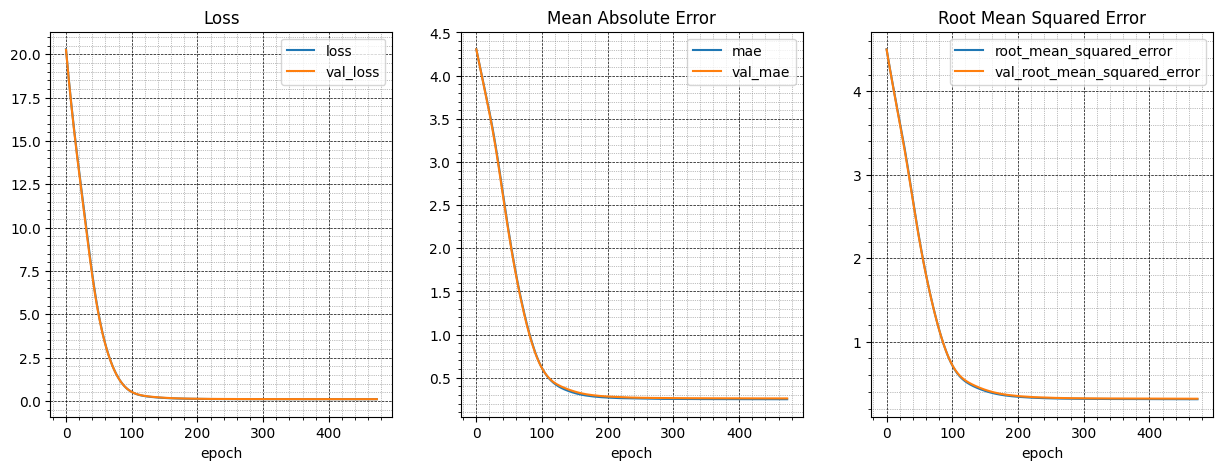

In [261]:
# need to extract the history dictionary from the keras callback:
history_data = history.history

# drop the r2 scores from the history, getting a dictionary of just loss:
history_plot = history_data
history_plot.pop('r2_score', None)
history_plot.pop('val_r2_score', None)

# list of metrics, text conversion, & halfway point:
metric_list = list(history_plot.keys())
half = int(len(history_plot.keys())/2)
metric2text = {'loss' : 'Loss',
               'mae' : 'Mean Absolute Error',
               'root_mean_squared_error': 'Root Mean Squared Error'
               }

# training history analysis:
plt.figure(figsize = (half * 5,5))

# iterate and plot the training values:
for index, metric in enumerate(metric_list[:half]):
    training_metric = metric
    validation_metric = metric_list[index + half]

    plt.subplot(1, half, index + 1)
    plt.plot(history_data[training_metric], label = training_metric)
    plt.plot(history_data[validation_metric], label = validation_metric)
    plt.xlabel('epoch')
    plt.legend(loc = 'upper right')
    plt.minorticks_on()
    plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
    plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
    plt.title(f'{metric2text[training_metric]}')

# **Utilize the Model:**

This section utilizes the model following its training. The goal is to see the accuracy of the model in inference, visualize the errors, and test the generalization of the model. 

In [262]:
# need to get the test metrics through model evaluation:
test_loss, test_mae, test_rmse, _ = model.evaluate(x_test, y_test)

# need to get the predictions of the model:
pred_start = time.time()
y_pred = model.predict(x_test)
pred_time = time.time() - pred_start

# get the R2 score:
test_r2 = r2_score(y_test, y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1019 - mae: 0.2581 - r2_score: 0.9594 - root_mean_squared_error: 0.3192
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


Check the memory consumption:

In [263]:
# import memory tracking functionalities:
import psutil
import os

# get process ID:
process = psutil.Process(os.getpid())

# get memory before and after prediction:
mem_before = process.memory_info().rss / 1024 ** 2
y_pred = model.predict(x_test)
mem_after = process.memory_info().rss / 1024 ** 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# **Model Results:**

This section serves to visualize the entirety of the results for testing the model. The metrics that are visualized are:

* MSE in testing
* MAE in testing
* RMSE in testing
* $R^{2}$ in testing
* Memory consumption of model
* Prediction time of model
* Actual vs. Predicted curve of model
* Histogram of prediction errors

In [264]:
# print model parameters to user:
print(f'test MSE was: {test_loss}\n',
      f'test MAE was: {test_mae}\n', 
      f'test RMSE was: {test_rmse}\n',
      f'test r2 score was: {test_r2}\n',
      f'memory used was: {(mem_after - mem_before)} MB\n',
      f'prediction time was: {round(pred_time, 3)} seconds')

test MSE was: 0.09840810298919678
 test MAE was: 0.25418171286582947
 test RMSE was: 0.3137006461620331
 test r2 score was: 0.9605336785316467
 memory used was: 0.0234375 MB
 prediction time was: 2.786 seconds


Scatter plot analysis of model:

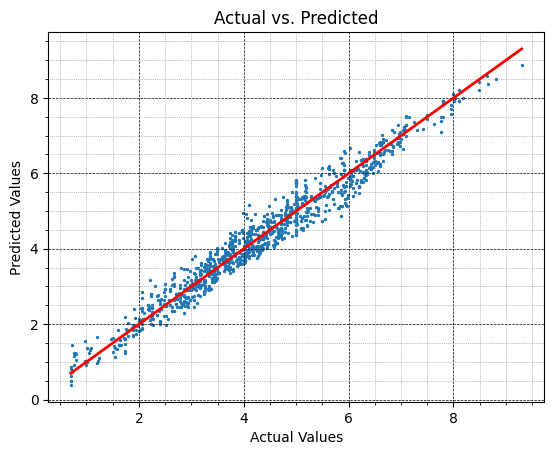

In [265]:
# scatter plot analysis:
plt.figure()
plt.scatter(y_test, y_pred, s = 2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', lw = 2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

Histogram analysis of model:

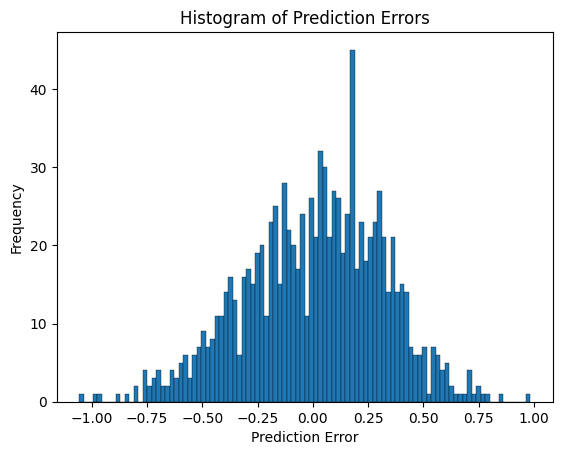

In [266]:
# histogram analysis:
y_test = np.array(y_test).reshape(-1, 1)
error = y_test - y_pred

plt.figure()
plt.hist(error, bins = 100, edgecolor = 'black', linewidth = 0.25)

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

plt.show()

# **Saving the Model:**
The model can then be saved for further use, where it can be deployed at its target destination (i.e. on a robot):

In [267]:
# need to set the model directory and the file type:
model_path = os.path.join(os.getcwd(), 'anfis_model.h5')

# save the model:
model.save(model_path)
print(f'model saved to: {model_path}')

model saved to: c:\Users\mtidd2\Desktop\Research\Inference Systems\Python_Design\ANFIS_Design\ANFIS_Model_Design\anfis_model.h5
